# Setting up

Building on top of Jacob's notebook to explore other variables individually

[Skip to 1% sample findings](#sample)

[Skip to transformations](#transformations)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None) 

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use("ggplot")

data = pd.read_csv('clean_diamond_df.csv')

In [2]:
data.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
0,0.23,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43,326
1,0.21,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31,326
2,0.23,Good,E,VS1,56.9,65.0,4.05,4.07,2.31,327
3,0.29,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63,334
4,0.31,Good,J,SI2,63.3,58.0,4.34,4.35,2.75,335


In [3]:
data.loc[data['cut'] == 'Very Good', 'cut'] = 'Very_Good'

In [4]:
data_encoded = pd.get_dummies(data, drop_first=True)
data_encoded.head()

,carat,depth,table,x,y,z,price,cut_Good,cut_Ideal,cut_Premium,cut_Very_Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,3.95,3.98,2.43,326,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
1,0.21,59.8,61.0,3.89,3.84,2.31,326,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0
2,0.23,56.9,65.0,4.05,4.07,2.31,327,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
3,0.29,62.4,58.0,4.20,4.23,2.63,334,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,0.31,63.3,58.0,4.34,4.35,2.75,335,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0


In [5]:
formula_string_indep_vars_encoded = ' + '.join(data_encoded.drop(columns='price').columns)
formula_string_encoded = 'price ~ ' + formula_string_indep_vars_encoded
print('formula_string_encoded: ', formula_string_encoded)

formula_string_encoded:  price ~ carat + depth + table + x + y + z + cut_Good + cut_Ideal + cut_Premium + cut_Very_Good + color_E + color_F + color_G + color_H + color_I + color_J + clarity_IF + clarity_SI1 + clarity_SI2 + clarity_VS1 + clarity_VS2 + clarity_VVS1 + clarity_VVS2


In [6]:
model_full = sm.formula.ols(formula=formula_string_encoded, data=data_encoded)
###
model_full_fitted = model_full.fit()
###
print(model_full_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 2.716e+04
Date:                Mon, 18 Oct 2021   Prob (F-statistic):               0.00
Time:                        13:59:05   Log-Likelihood:            -4.5524e+05
No. Observations:               53917   AIC:                         9.105e+05
Df Residuals:                   53893   BIC:                         9.107e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -5012.9949    654.932     -7.654

## Full Model Diagnostic Checks

We observe a clear non-linear relationship in the residual plots, which suggests that transformation of our data may be required or that a linear regression model may not be that suitable.

In [7]:
residuals_full = pd.DataFrame({'actual': data_encoded['price'], 
                            'predicted': model_full_fitted.fittedvalues, 
                            'residual': model_full_fitted.resid})

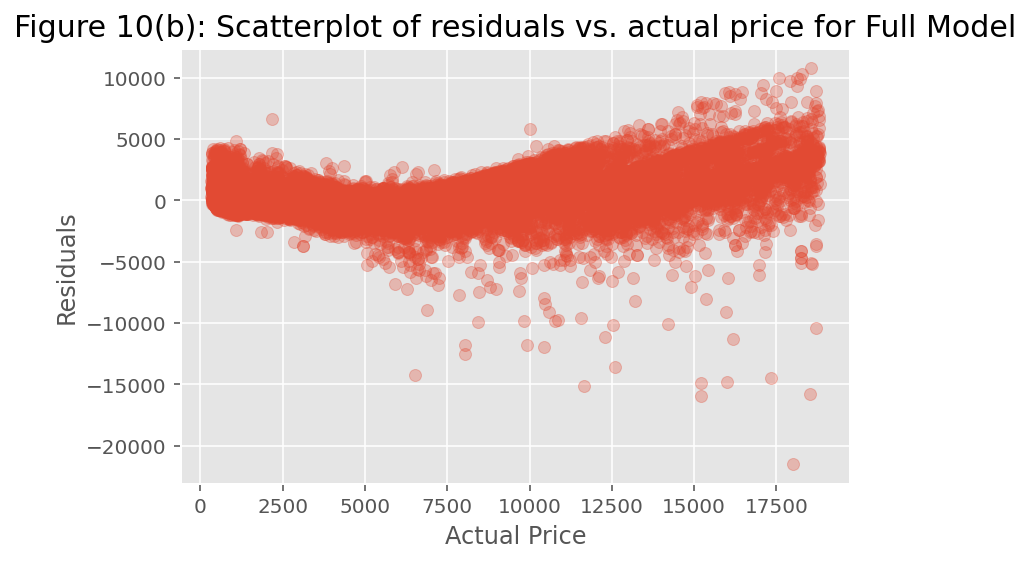

In [8]:
plt.scatter(residuals_full['actual'], residuals_full['residual'], alpha=0.3);
plt.xlabel('Actual Price');
plt.ylabel('Residuals')
plt.title('Figure 10(b): Scatterplot of residuals vs. actual price for Full Model', fontsize=15)
plt.show();

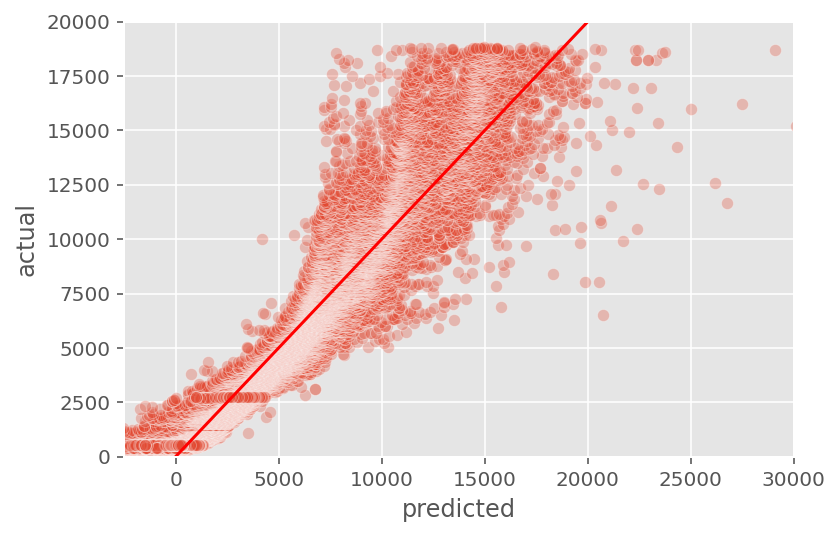

In [9]:
def plot_line(axis, slope, intercept, **kargs):
    xmin, xmax = axis.get_xlim()
    plt.plot([xmin, xmax], [xmin*slope+intercept, xmax*slope+intercept], **kargs)

sns.scatterplot(x=residuals_full['predicted'], y=residuals_full['actual'], alpha=0.3)
plt.xlim(-2500, 30000)
plt.ylim(0, 20000)
plot_line(axis=plt.gca(), slope=1, intercept=0, c="red");
plt.show()

The predicted vs actual price scatterplot appears to show an association with R-Squared value much below 0.92. We will visualise a small sample of this entire dataset to further explore this finding.

# Visualising 1% sample <a id="sample"></a>

The full dataset (graphed above) contains over 50,000 values, we will visualise the residuals of a sample taking 1% of the values from the original dataset. This will assist in clearer visualisation of the residuals
* we want to confirm the high R-squared value of 0.921

In [10]:
sample = data_encoded.sample(frac=0.01, random_state=90)
sample.shape

(539, 24)

In [11]:
model_full = sm.formula.ols(formula=formula_string_encoded, data=sample)
###
model_full_fitted = model_full.fit()
###
print(model_full_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     311.4
Date:                Mon, 18 Oct 2021   Prob (F-statistic):          7.22e-285
Time:                        13:59:06   Log-Likelihood:                -4528.5
No. Observations:                 539   AIC:                             9105.
Df Residuals:                     515   BIC:                             9208.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -2.457e+04   1.17e+04     -2.097

In [12]:
sample_residuals_full = pd.DataFrame({'actual': data_encoded['price'], 
                            'predicted': model_full_fitted.fittedvalues, 
                            'residual': model_full_fitted.resid})

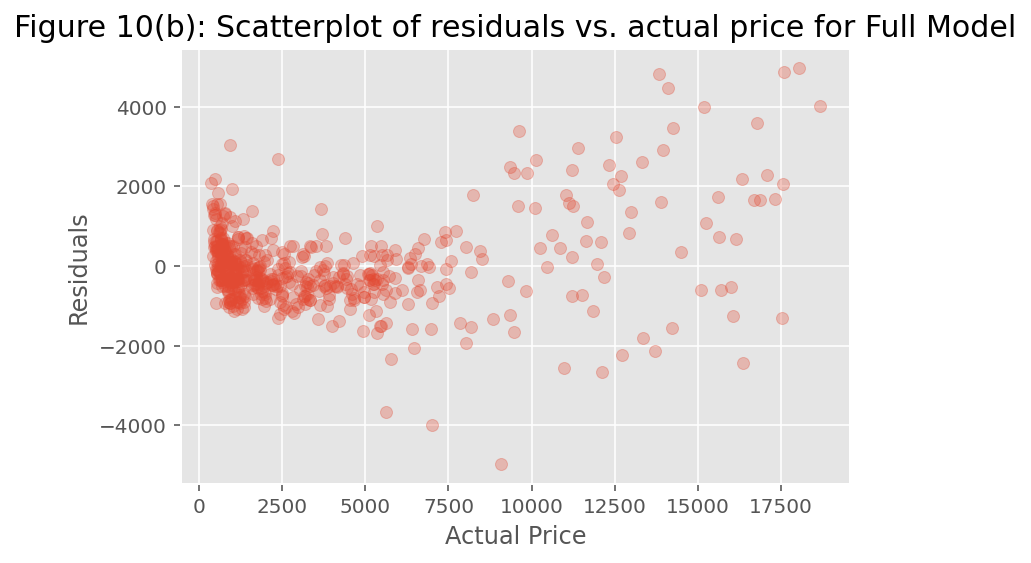

In [13]:
plt.scatter(sample_residuals_full['actual'], sample_residuals_full['residual'], alpha=0.3);
plt.xlabel('Actual Price');
plt.ylabel('Residuals')
plt.title('Figure 10(b): Scatterplot of residuals vs. actual price for Full Model', fontsize=15)
plt.show();

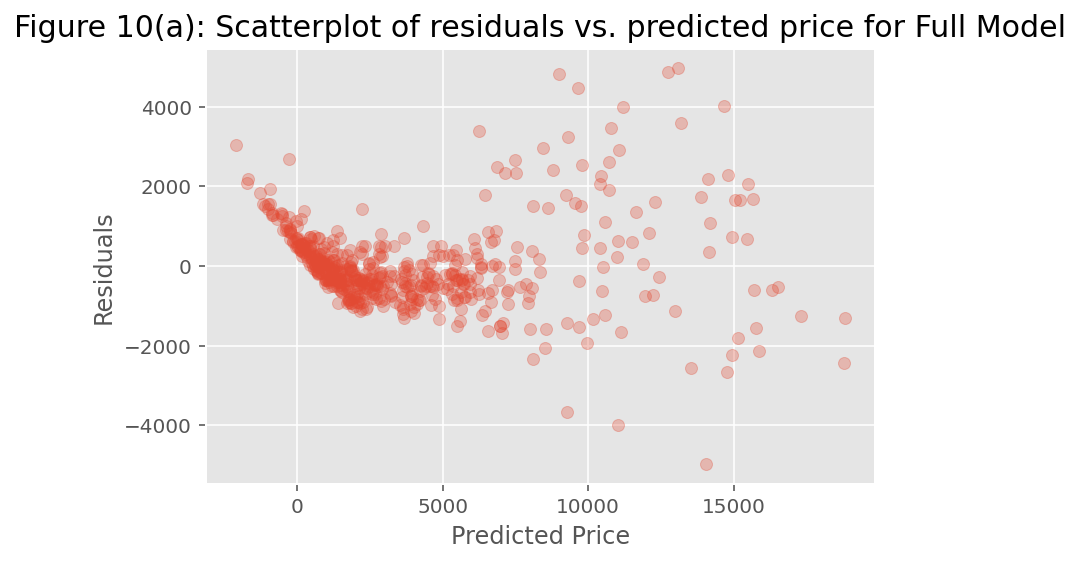

In [14]:
plt.scatter(sample_residuals_full['predicted'], sample_residuals_full['residual'], alpha=0.3);
plt.xlabel('Predicted Price');
plt.ylabel('Residuals')
plt.title('Figure 10(a): Scatterplot of residuals vs. predicted price for Full Model', fontsize=15)
plt.show();

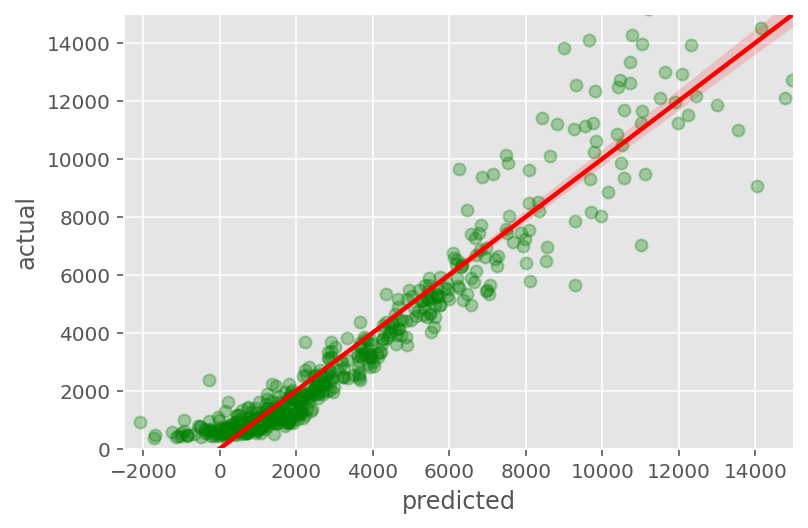

In [15]:
sns.regplot(x=sample_residuals_full['predicted'], y=sample_residuals_full['actual'], scatter_kws={"color": "g", 'alpha':0.3}, line_kws={"color": "red"})
plt.xlim(-2500, 15000)
plt.ylim(0, 15000)
plt.show()

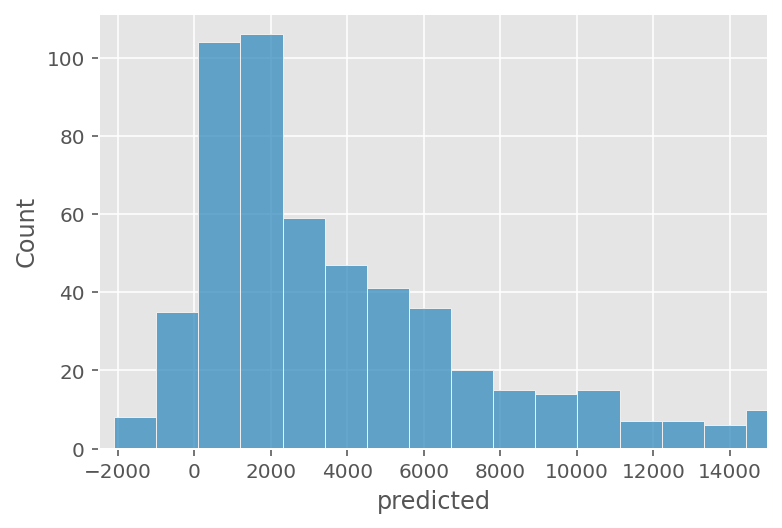

In [16]:
sns.histplot(x=sample_residuals_full['predicted'])
plt.xlim(-2500, 15000)
plt.show()

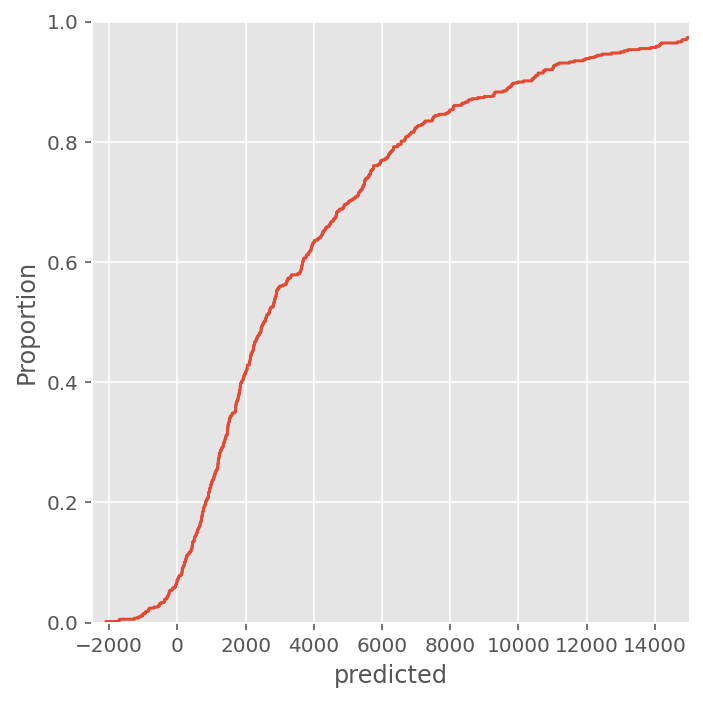

In [17]:
sns.displot(x=sample_residuals_full['predicted'], kind="ecdf")
plt.xlim(-2500, 15000)
plt.show()

Observing the scatterplots of residuals and predicted/actual values for the ENTIRE dataset appear to show an association that doesnt match the R-squared value of 0.92. This may be due to the limitations of visualising large amounts of values on a single scatterplot.

Taking 1% of the dataset (500 values from 50000), we can better observe the density/distribution of predicted vs actual values. For the majority of the values (between 0 and 2000$ in predicted value), the predicted value is very close to the actual value. The R-Squared value of ~0.92 can be visually observed.
* Using seaborn's regplot function, the line of best fit is almost exactly what we expect it to be - an exact 1-to-1 relationship between predicted and actual price.
* As predicted/actual price increase, the variability increases as well (breaking the constant variability assumption)
* However, only <20\% amount of the data exist in this region (based on the empirical cumulative distribution function graph)

From this we can see that scatterplots of the full dataset are misleading, due to it's size (50000+ values), we cannot comparitively observe the densities of points.

We could potentially limit the maximum price of diamonds in our model to around $8000, where we start to observe inconsistent variability.

Additionally, the curved pattern observed in the residual plots can also be seen in the actual vs predicted graph. Based on the ECDF graph, about 5% of the values result in a negative predicted price, which causes the bending on the left of the residual plots. 
* Setting a minimum price for our data may also help remove this non-linearity

Lastly, from the OLS regression results of our 1% sample, we can see that some variables have a P value >0.05. **Need to further explore how n affects P values**

### Exploring the predictive qualities of Depth <a id="depth"></a>

From the Phase 1 data exploration, we found that depth had little to no association with price. To confirm our findings we fit an OLS model to fit depth, alone, against price.
* We observe that there is an R-squared of 0.000
* 0% of the variance in price can be explained by depth

We may consider dropping this variable, however, we will test depth against carat to see if depth has a different effect when paired with another variable.
* price ~ carat produces an R-squared value of 0.849
* price ~ carat + depth produces an R-squared value of 0.851

It appears as if Depth assists in explaining variance in price when paired with other variables.
(side note: **see why Adj. R-squared is the same as R-squared, even for regression analyses with very few independent variables**)

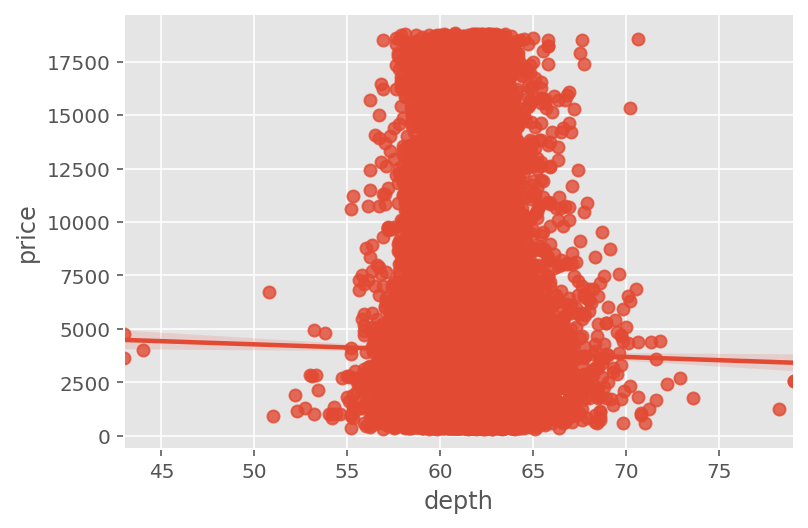

In [18]:
sns.regplot(x=data['depth'], y=data['price'])
plt.show()

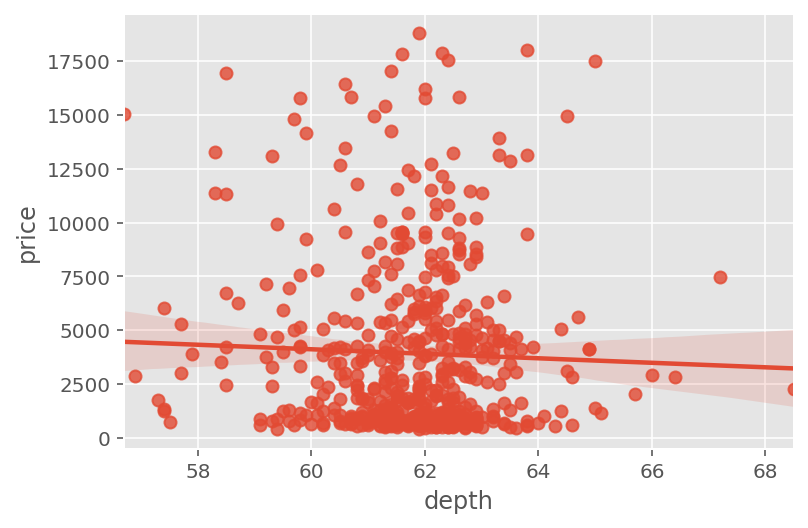

In [19]:
# Only plotting 1% of points to observe underlying patterns
sampled_data = data.sample(frac=0.01, random_state=98)
sns.regplot(x=sampled_data['depth'], y=sampled_data['price'])
plt.show()

In [20]:
test_string_encoded = 'price ~ depth'
model_full = sm.formula.ols(formula=test_string_encoded, data=data_encoded)
###
model_full_fitted = model_full.fit()
###
print(model_full_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     6.119
Date:                Mon, 18 Oct 2021   Prob (F-statistic):             0.0134
Time:                        13:59:10   Log-Likelihood:            -5.2352e+05
No. Observations:               53917   AIC:                         1.047e+06
Df Residuals:                   53915   BIC:                         1.047e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5762.0334    740.460      7.782      0.0

In [21]:
test_string_encoded = 'price ~ carat'
model_full = sm.formula.ols(formula=test_string_encoded, data=data_encoded)
###
model_full_fitted = model_full.fit()
###
print(model_full_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                 3.039e+05
Date:                Mon, 18 Oct 2021   Prob (F-statistic):               0.00
Time:                        13:59:11   Log-Likelihood:            -4.7250e+05
No. Observations:               53917   AIC:                         9.450e+05
Df Residuals:                   53915   BIC:                         9.450e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2255.8565     13.053   -172.823      0.0

In [22]:
test_string_encoded = 'price ~ depth + carat'
model_full = sm.formula.ols(formula=test_string_encoded, data=data_encoded)
###
model_full_fitted = model_full.fit()
###
print(model_full_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                 1.536e+05
Date:                Mon, 18 Oct 2021   Prob (F-statistic):               0.00
Time:                        13:59:11   Log-Likelihood:            -4.7226e+05
No. Observations:               53917   AIC:                         9.445e+05
Df Residuals:                   53914   BIC:                         9.445e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4065.4842    286.169     14.207      0.0

### Exploring the predictive qualities of Table

From the Phase 1 data exploration, we also found that table had little to no association with price. To confirm our findings we fit an OLS model to fit table, alone, against price.
* We observe that there is an R-squared of 0.016
* 1.6% of the variance in price can be explained by table

It is an extremely weak correlation, however, will improve the R-squared value of our model.

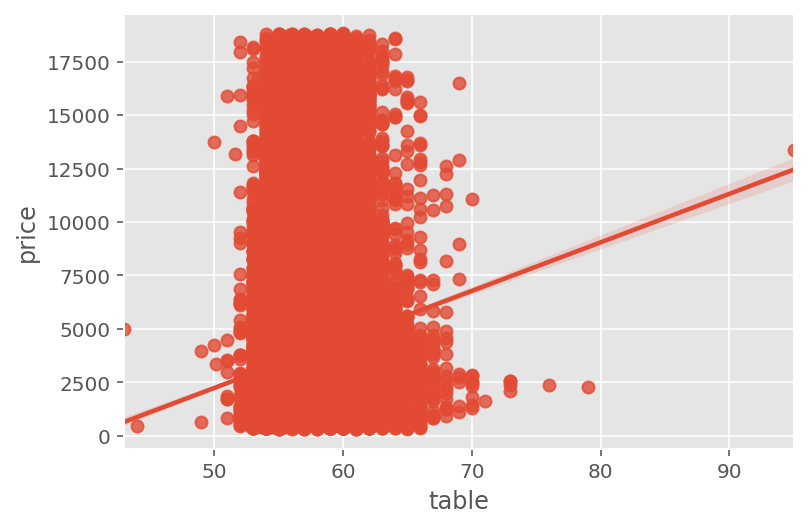

In [23]:
sns.regplot(x=data['table'], y=data['price'])
plt.show()

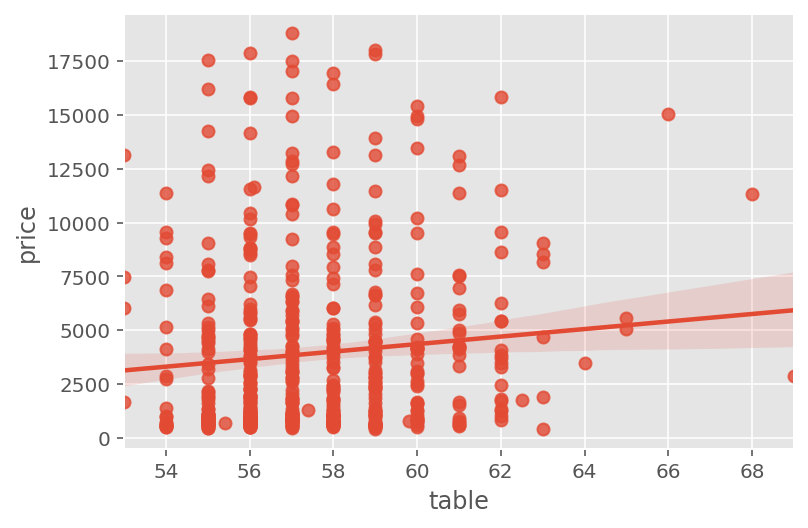

In [24]:
sampled_data = data.sample(frac=0.01, random_state=98)
sns.regplot(x=sampled_data['table'], y=sampled_data['price'])
plt.show()

In [25]:
test_string_encoded = 'price ~ table'
model_full = sm.formula.ols(formula=test_string_encoded, data=data_encoded[["price", "table"]])
###
model_full_fitted = model_full.fit()
###
print(model_full_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     887.3
Date:                Mon, 18 Oct 2021   Prob (F-statistic):          2.14e-193
Time:                        13:59:14   Log-Likelihood:            -5.2308e+05
No. Observations:               53917   AIC:                         1.046e+06
Df Residuals:                   53915   BIC:                         1.046e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -9117.0848    438.374    -20.798      0.0

## Transformations <a id="transformations"></a>

We will individually transform variables to test if we can increase the R-squared value of our model.
From Phase 1, we observed that X, Y, Z variables had very clear non-linear associations with price, following a squared or cubic pattern. 

In order to attempt to linearise this, we will apply an x squared and x cubed transformation to the variable.

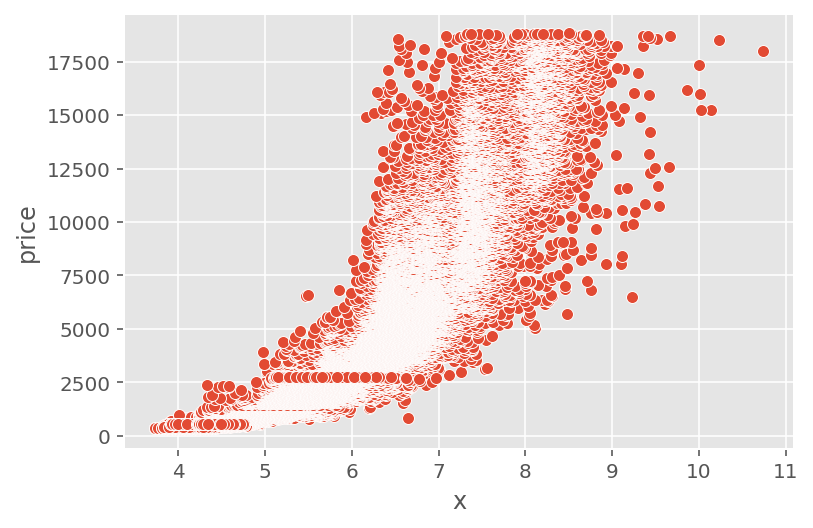

In [26]:
sns.scatterplot(x="x", y="price", data=data_encoded)
plt.show()

<AxesSubplot:xlabel='x_squared', ylabel='price'>

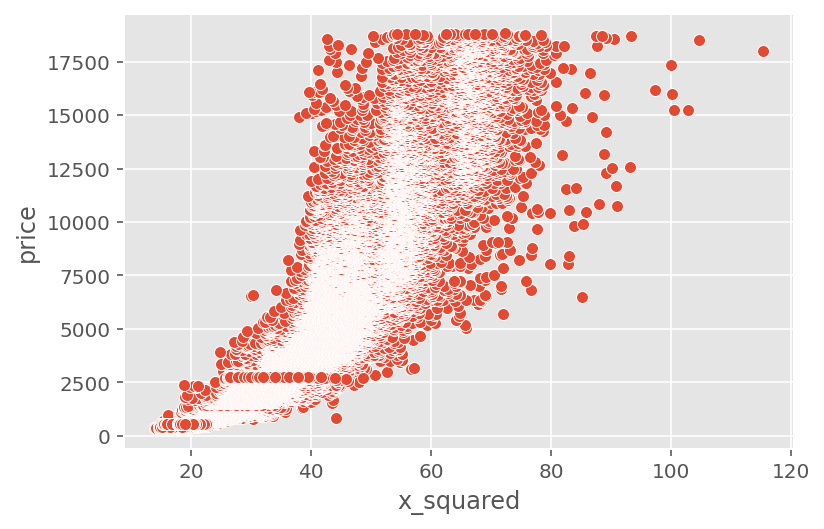

In [27]:
data_encoded["x_squared"] = data_encoded["x"] ** 2
sns.scatterplot(x="x_squared", y="price", data=data_encoded)

<AxesSubplot:xlabel='x_cubed', ylabel='price'>

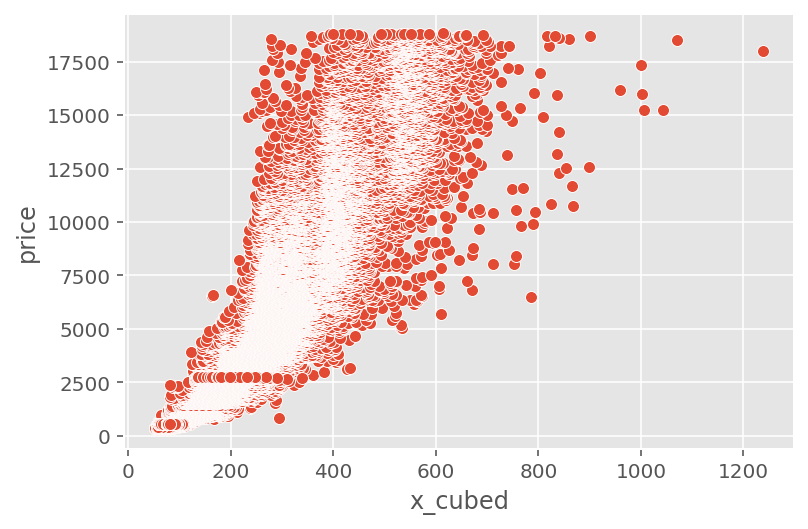

In [28]:
data_encoded["x_cubed"] = data_encoded["x"] ** 3
sns.scatterplot(x="x_cubed", y="price", data=data_encoded)

<AxesSubplot:xlabel='x_fourth', ylabel='price'>

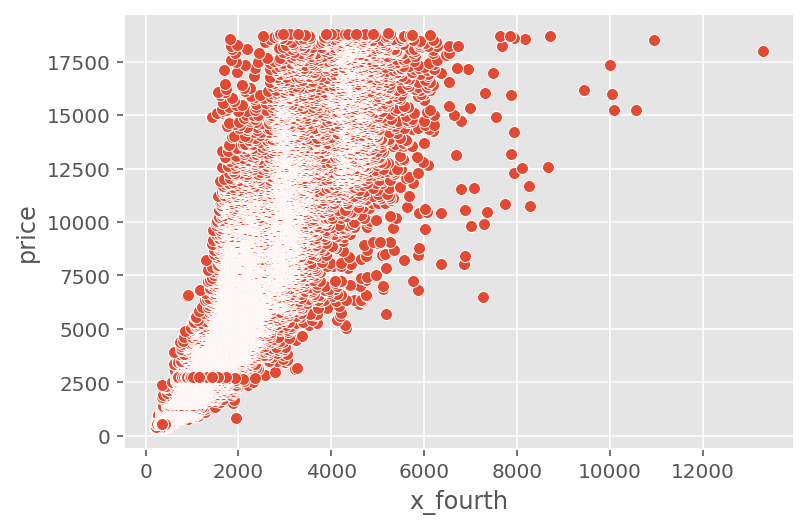

In [29]:
data_encoded["x_fourth"] = data_encoded["x"] ** 4
sns.scatterplot(x="x_fourth", y="price", data=data_encoded)

In [30]:
test_string_encoded = 'price ~ x'
model_full = sm.formula.ols(formula=test_string_encoded, data=data_encoded)
###
model_full_fitted = model_full.fit()
###
print("OLS model for Price ~ X produces R-Squared value of: ", model_full_fitted.rsquared)

OLS model for Price ~ X produces R-Squared value of:  0.7871614773999794


In [31]:
test_string_encoded = 'price ~ x_squared'
model_full = sm.formula.ols(formula=test_string_encoded, data=data_encoded)
###
model_full_fitted = model_full.fit()
###
print("OLS model for Price ~ X^2 produces R-Squared value of: ", model_full_fitted.rsquared)

OLS model for Price ~ X^2 produces R-Squared value of:  0.8274480050613037


In [32]:
test_string_encoded = 'price ~ x_cubed'
model_full = sm.formula.ols(formula=test_string_encoded, data=data_encoded)
###
model_full_fitted = model_full.fit()
###
print("OLS model for Price ~ X^3 produces R-Squared value of: ", model_full_fitted.rsquared)

OLS model for Price ~ X^3 produces R-Squared value of:  0.850171465606506


In [33]:
test_string_encoded = 'price ~ x_fourth'
model_full = sm.formula.ols(formula=test_string_encoded, data=data_encoded)
###
model_full_fitted = model_full.fit()
###
print("OLS model for Price ~ X^4 produces R-Squared value of: ", model_full_fitted.rsquared)

OLS model for Price ~ X^4 produces R-Squared value of:  0.8525233927426286


We can see the R-squared value approach a value of ~0.85 as we increase the power of the x transformation. X^4 appears to yield the highest R-squared value.

Todo: **Graph line plot of X power vs R-squared value to visualise**

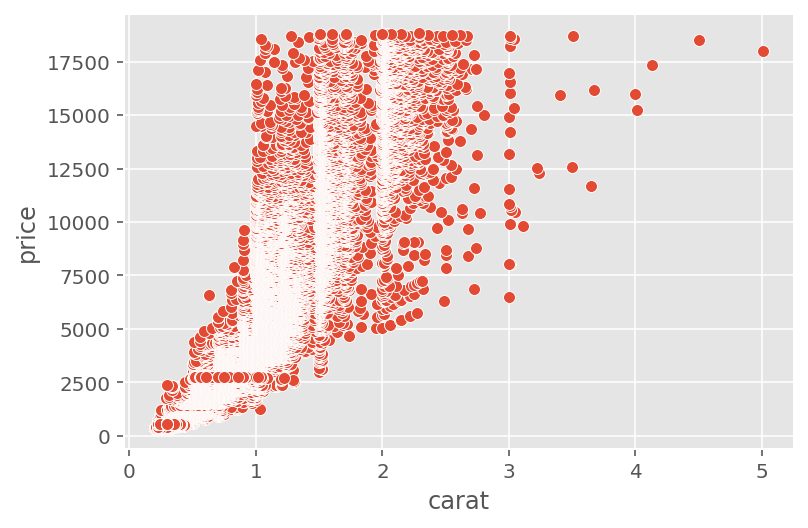

In [34]:
sns.scatterplot(x="carat", y="price", data=data_encoded)
plt.show()

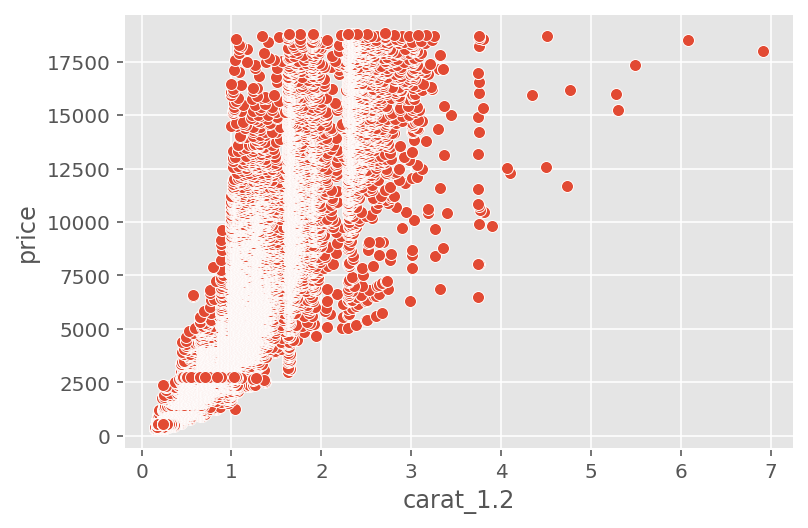

In [35]:
data_encoded["carat_1.2"] = data_encoded["carat"] ** 1.2
sns.scatterplot(x="carat_1.2", y="price", data=data_encoded)
plt.show()

In [36]:
test_string_encoded = 'price ~ carat'
model_full = sm.formula.ols(formula=test_string_encoded, data=data_encoded)
###
model_full_fitted = model_full.fit()
###
print("OLS model for Price ~ X produces R-Squared value of: ", model_full_fitted.rsquared)

OLS model for Price ~ X produces R-Squared value of:  0.8493201274671617


In [37]:
test_string_encoded = 'price ~ carat_squared'
model_full = sm.formula.ols(formula=test_string_encoded, data=data_encoded)
###
model_full_fitted = model_full.fit()
###
print("OLS model for Price ~ X produces R-Squared value of: ", model_full_fitted.rsquared)

PatsyError: Error evaluating factor: NameError: name 'carat_squared' is not defined
    price ~ carat_squared
            ^^^^^^^^^^^^^

Price ~ Carat reaches a max R-Squared when we transform Carat ^ 1.2. The increased benefits are very marginal and would make interpretation of the carat variable difficult and tedious. It is probably not worth it to apply this transformation.

**Based on phase 1, carat can be quite predictably calculated based on cuboidal volume (x*y*z), this may mean that transforming the 3 dimensional variables and dropping carat may yield a stronger model.**

### Applying transformations to the entire model

When we test the R-squared value of price ~ x + all other **categorical** variables, we get an R-Squared value of **0.843756**

When we test the R-squared value of price ~ x^4 + all other **categorical** variables, we get an R-Squared value of **0.9109**

* As the only numerical variable in the model, transforming x increases the strength of the model

In [38]:
test_string_encoded = 'price ~ x + cut_Good + cut_Ideal + cut_Premium + cut_Very_Good + color_E + color_F + color_G + color_H + color_I + color_J + clarity_IF + clarity_SI1 + clarity_SI2 + clarity_VS1 + clarity_VS2 + clarity_VVS1 + clarity_VVS2'
model_full = sm.formula.ols(formula=test_string_encoded, data=data_encoded)
###
model_full_fitted = model_full.fit()
###
print("R-Squared of price ~ x and all CATEGORICAL variables: ", model_full_fitted.rsquared)

R-Squared of price ~ x and all CATEGORICAL variables:  0.8437568668937631


In [39]:
test_string_encoded = 'price ~ x_fourth + cut_Good + cut_Ideal + cut_Premium + cut_Very_Good + color_E + color_F + color_G + color_H + color_I + color_J + clarity_IF + clarity_SI1 + clarity_SI2 + clarity_VS1 + clarity_VS2 + clarity_VVS1 + clarity_VVS2'
model_full = sm.formula.ols(formula=test_string_encoded, data=data_encoded)
###
model_full_fitted = model_full.fit()
###
print("R-Squared of price ~ x^4 and all CATEGORICAL variables: ", model_full_fitted.rsquared)

R-Squared of price ~ x^4 and all CATEGORICAL variables:  0.9108991555022052


When we test the R-squared value of price ~ x + all other **categorical + numerical** variables, we get an R-Squared value of **0.9206**

However, when we test the R-squared value of price ~ x^4 + all other **categorical + numerical** variables, we get an R-Squared value of **0.9203**

* When we mix x^4 with other original numerical variables, the predictive strength of the model is decreased.
* This suggests that x may need to be transformed in conjunction with the other variables

In [40]:
test_string_encoded = 'price ~ x + carat + y + z + depth + table + cut_Good + cut_Ideal + cut_Premium + cut_Very_Good + color_E + color_F + color_G + color_H + color_I + color_J + clarity_IF + clarity_SI1 + clarity_SI2 + clarity_VS1 + clarity_VS2 + clarity_VVS1 + clarity_VVS2'
model_full = sm.formula.ols(formula=test_string_encoded, data=data_encoded)
###
model_full_fitted = model_full.fit()
###
print("R-Squared of price ~ x and ALL other variables: ", model_full_fitted.rsquared)

R-Squared of price ~ x and ALL other variables:  0.9205774447870843


In [41]:
test_string_encoded = 'price ~ x_fourth + carat + y + z + depth + table + cut_Good + cut_Ideal + cut_Premium + cut_Very_Good + color_E + color_F + color_G + color_H + color_I + color_J + clarity_IF + clarity_SI1 + clarity_SI2 + clarity_VS1 + clarity_VS2 + clarity_VVS1 + clarity_VVS2'
model_full = sm.formula.ols(formula=test_string_encoded, data=data_encoded)
###
model_full_fitted = model_full.fit()
###
print("R-Squared of price ~ x^4 and ALL other variables: ", model_full_fitted.rsquared)

R-Squared of price ~ x^4 and ALL other variables:  0.920275117192205
